[01/12] linear_sep      best_acc  poly=0.9990  gelu=0.9951   params poly=1026 gelu=898


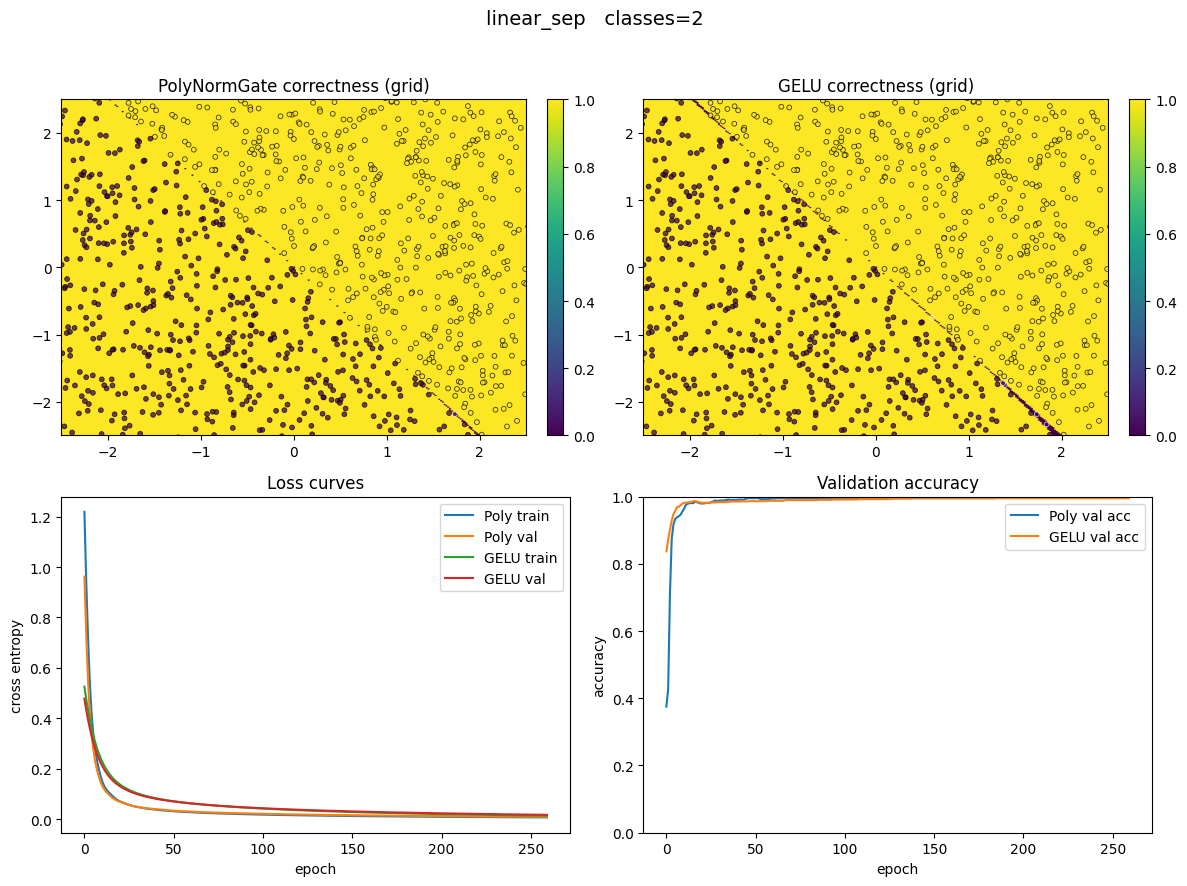

[02/12] xor             best_acc  poly=0.9961  gelu=0.9941   params poly=1026 gelu=898


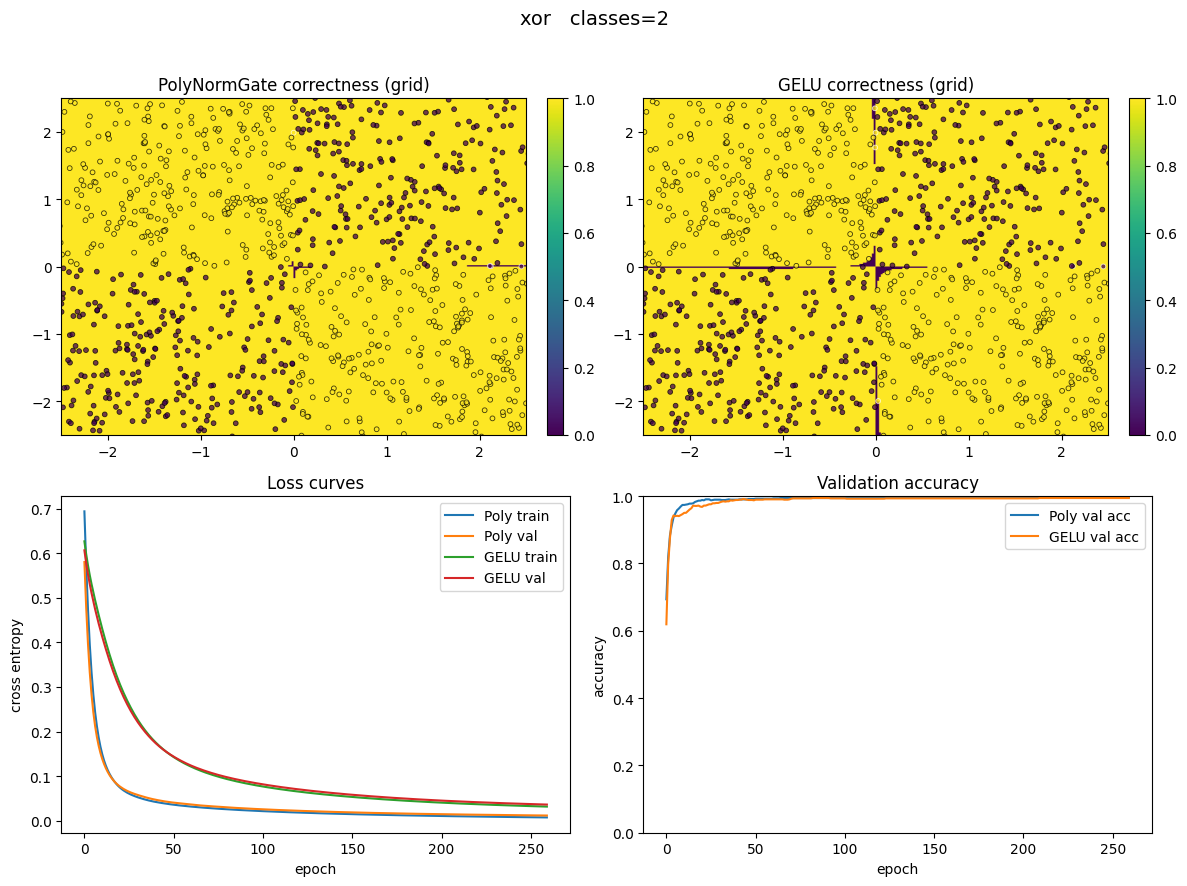

[03/12] circle          best_acc  poly=0.9990  gelu=0.9971   params poly=1026 gelu=898


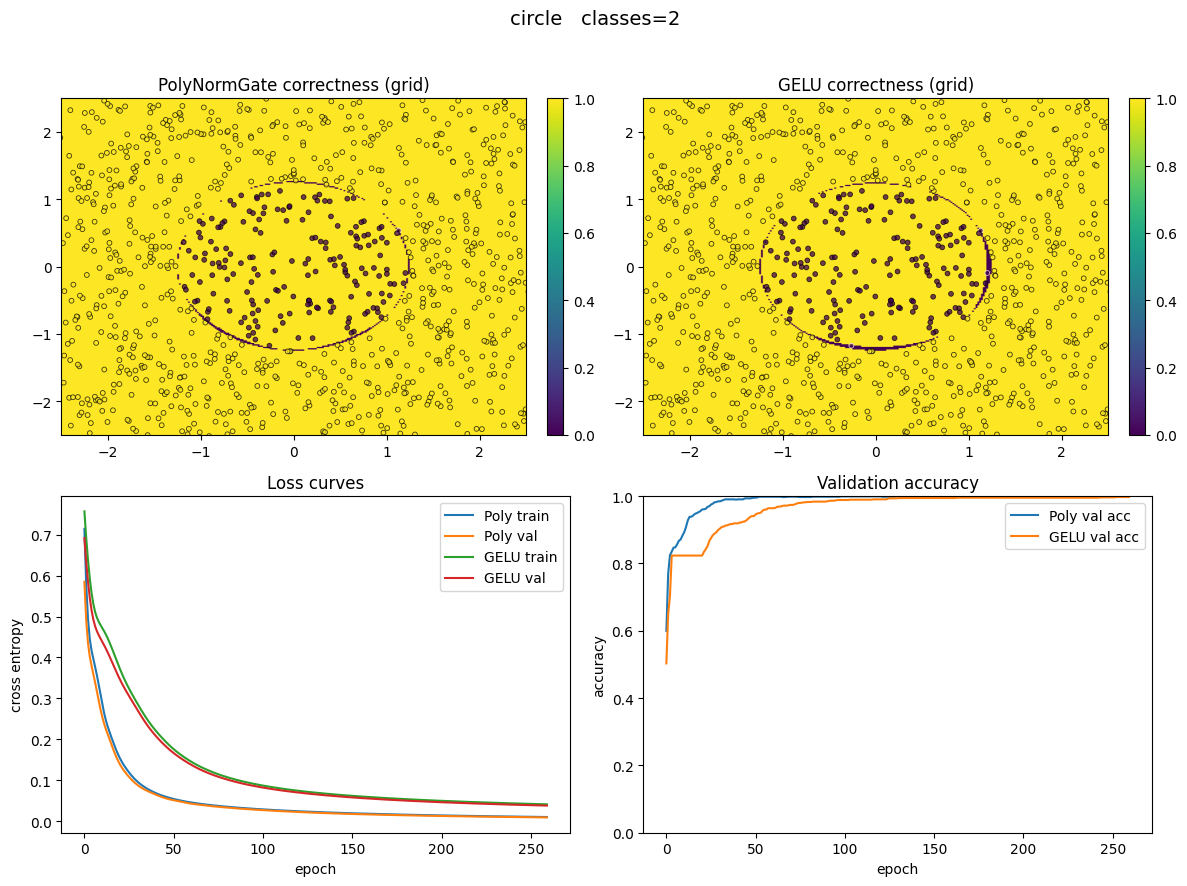

[04/12] ring            best_acc  poly=0.9971  gelu=0.9219   params poly=1026 gelu=898


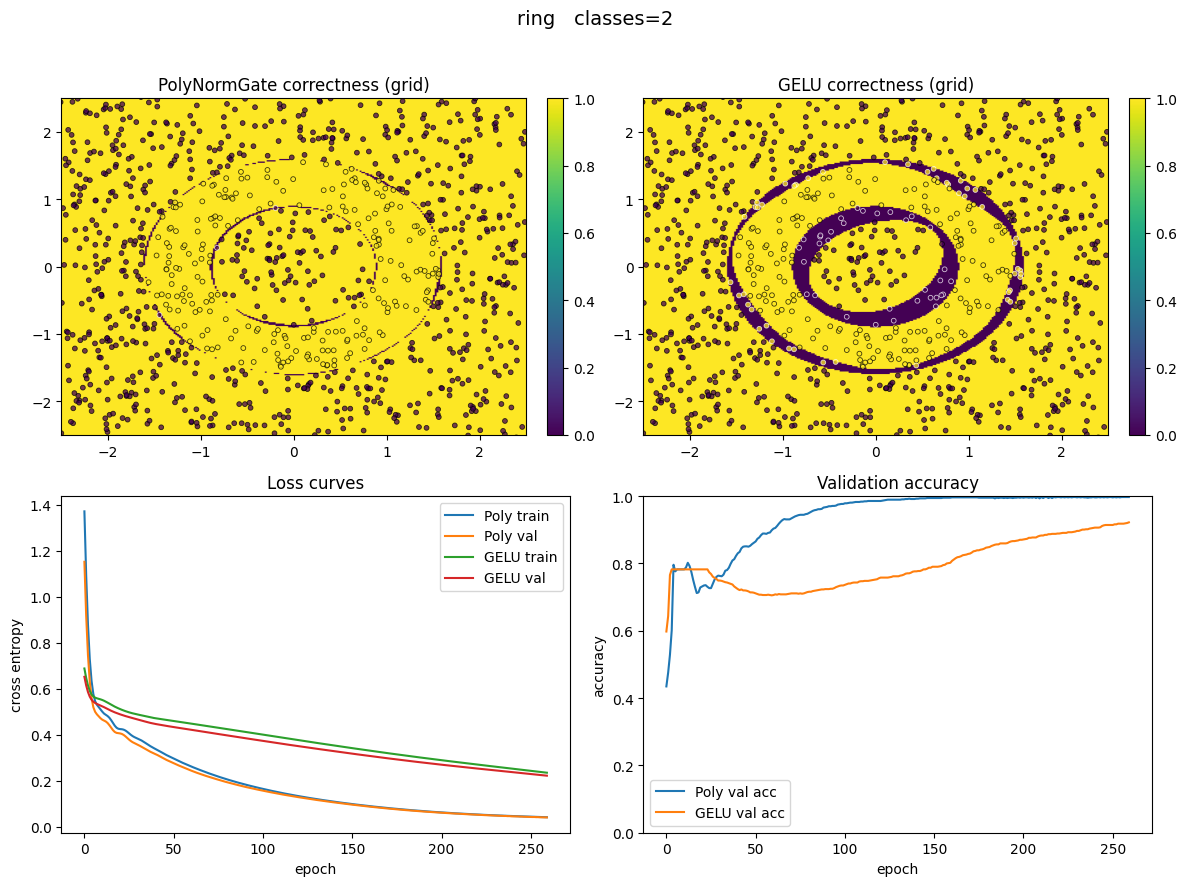

[05/12] checkerboard    best_acc  poly=0.7393  gelu=0.6387   params poly=1026 gelu=898


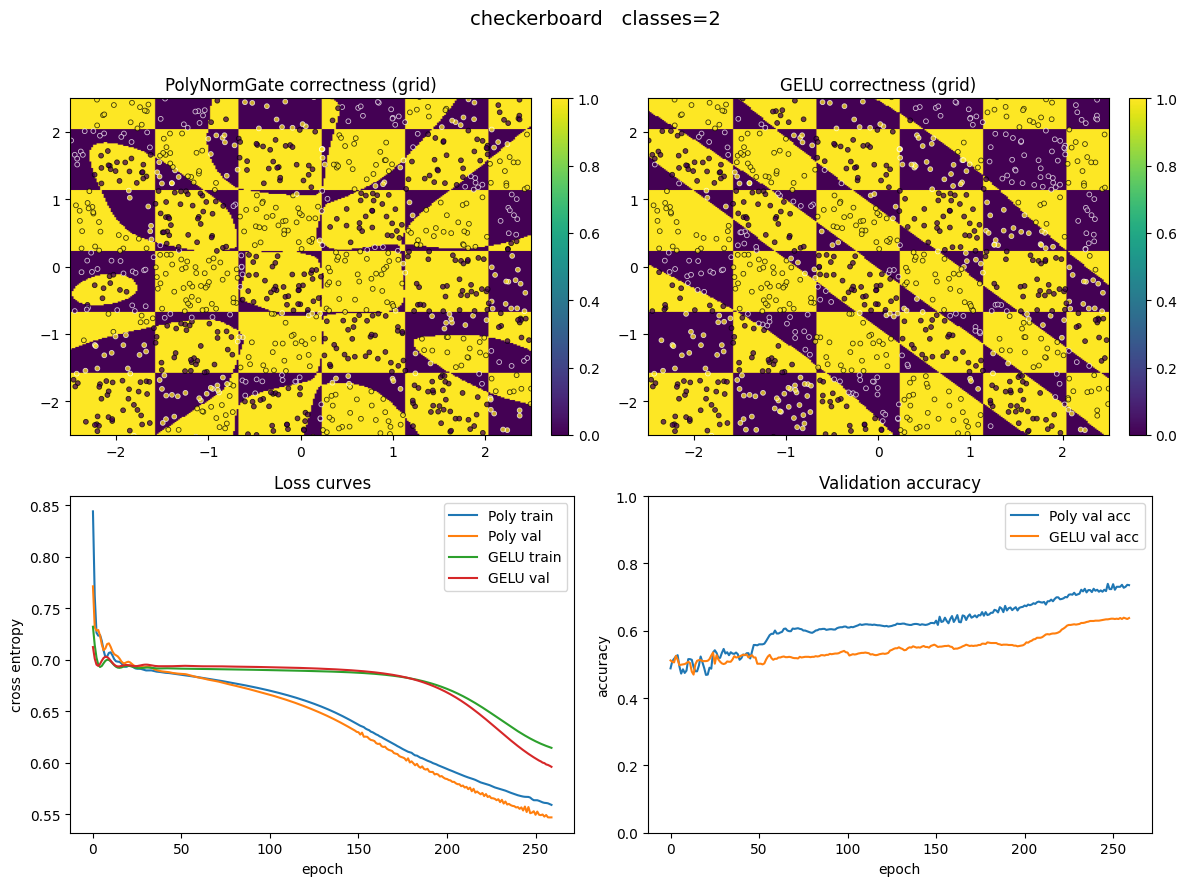

[06/12] sine_boundary   best_acc  poly=0.9990  gelu=0.9912   params poly=1026 gelu=898


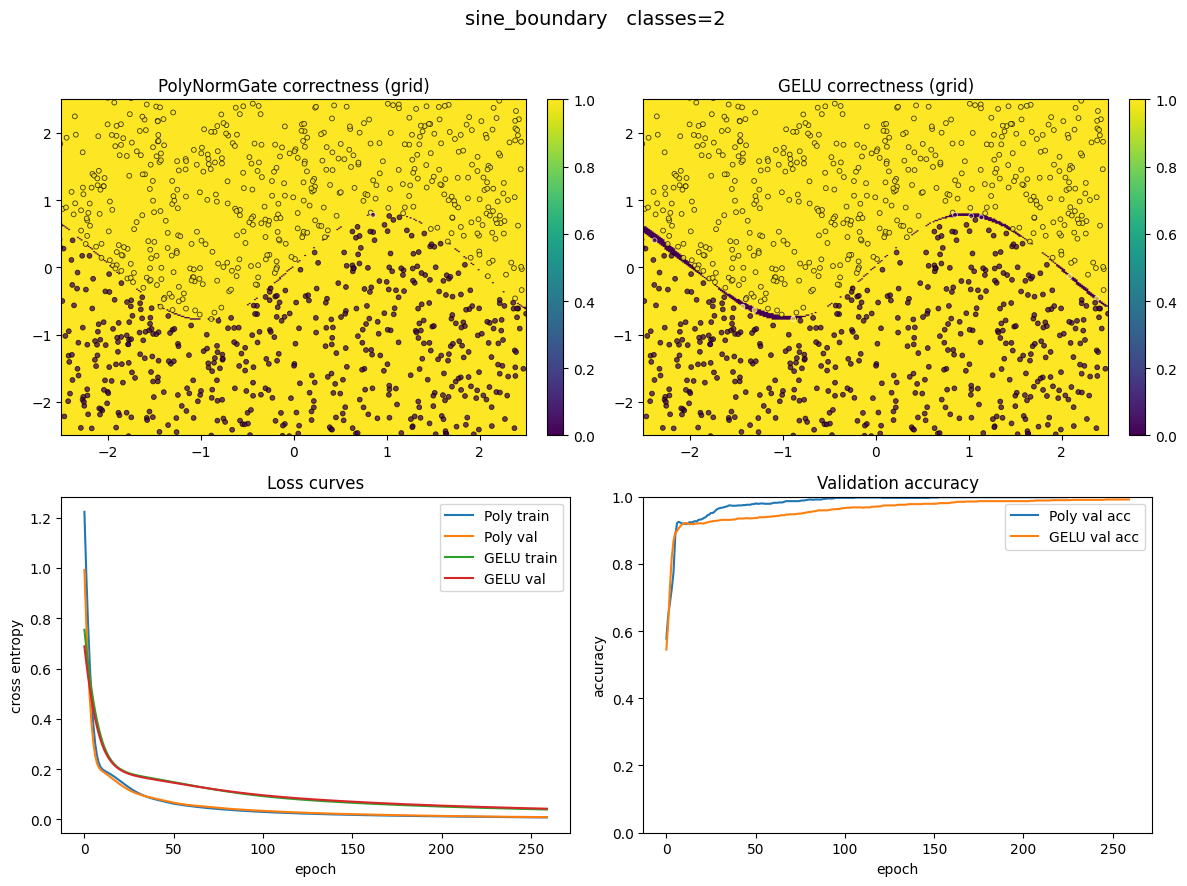

[07/12] cubic_boundary  best_acc  poly=0.9990  gelu=0.9961   params poly=1026 gelu=898


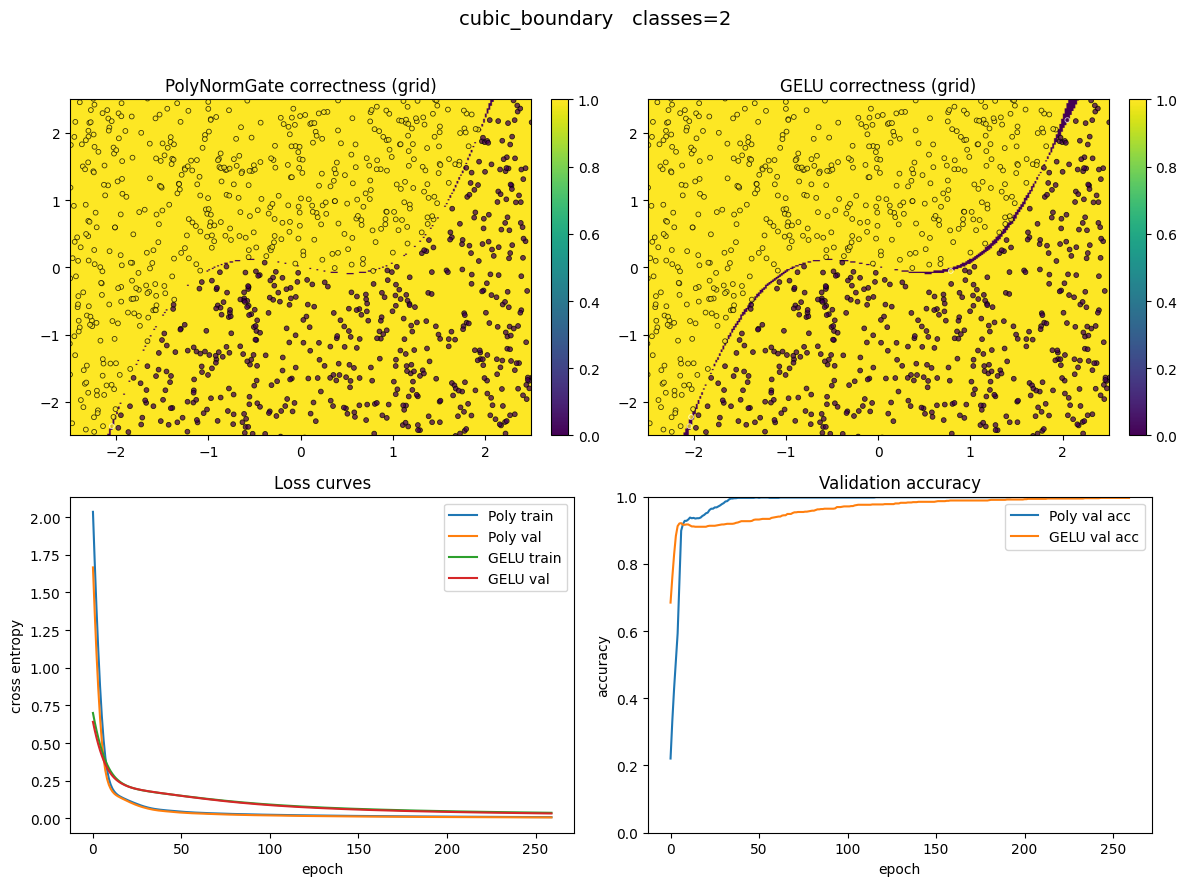

[08/12] spiral          best_acc  poly=0.9775  gelu=0.9209   params poly=1026 gelu=898


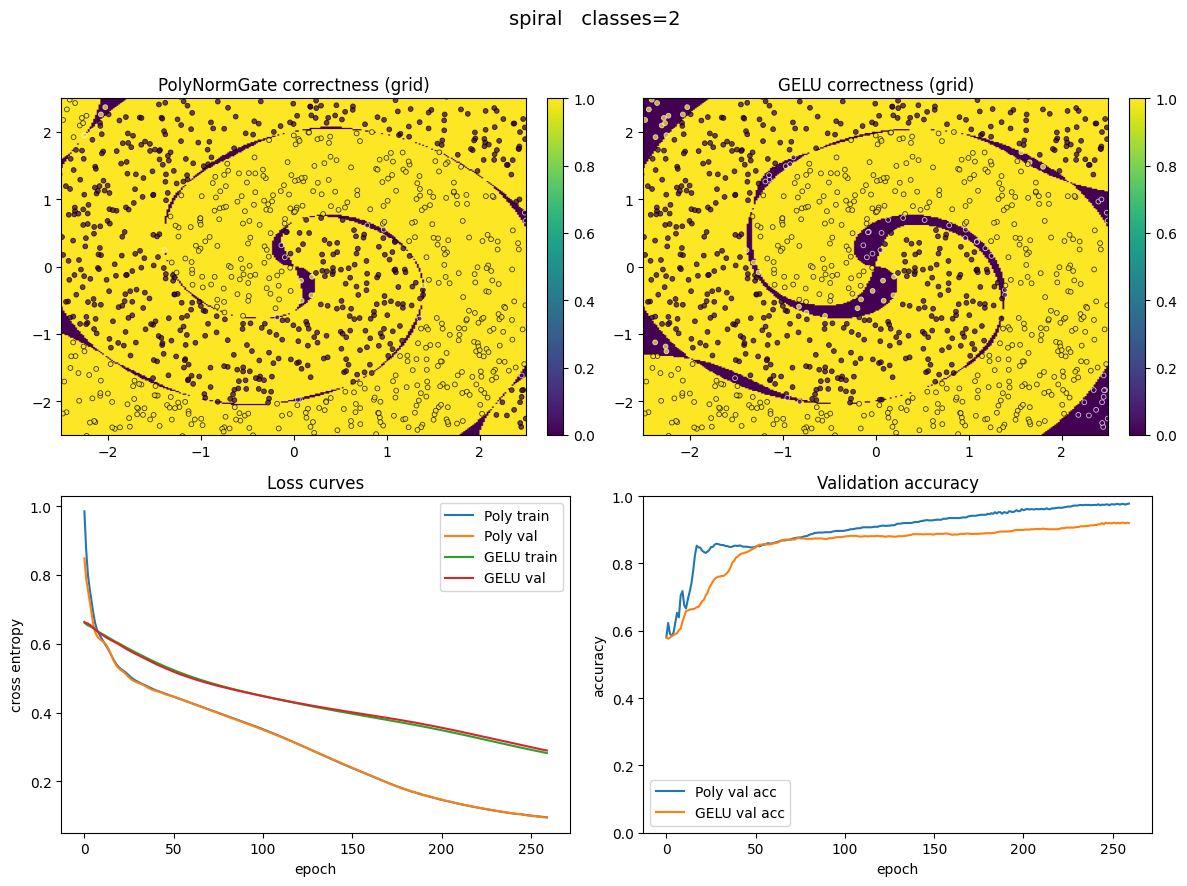

[09/12] sectors4        best_acc  poly=0.9990  gelu=0.9971   params poly=1284 gelu=1156


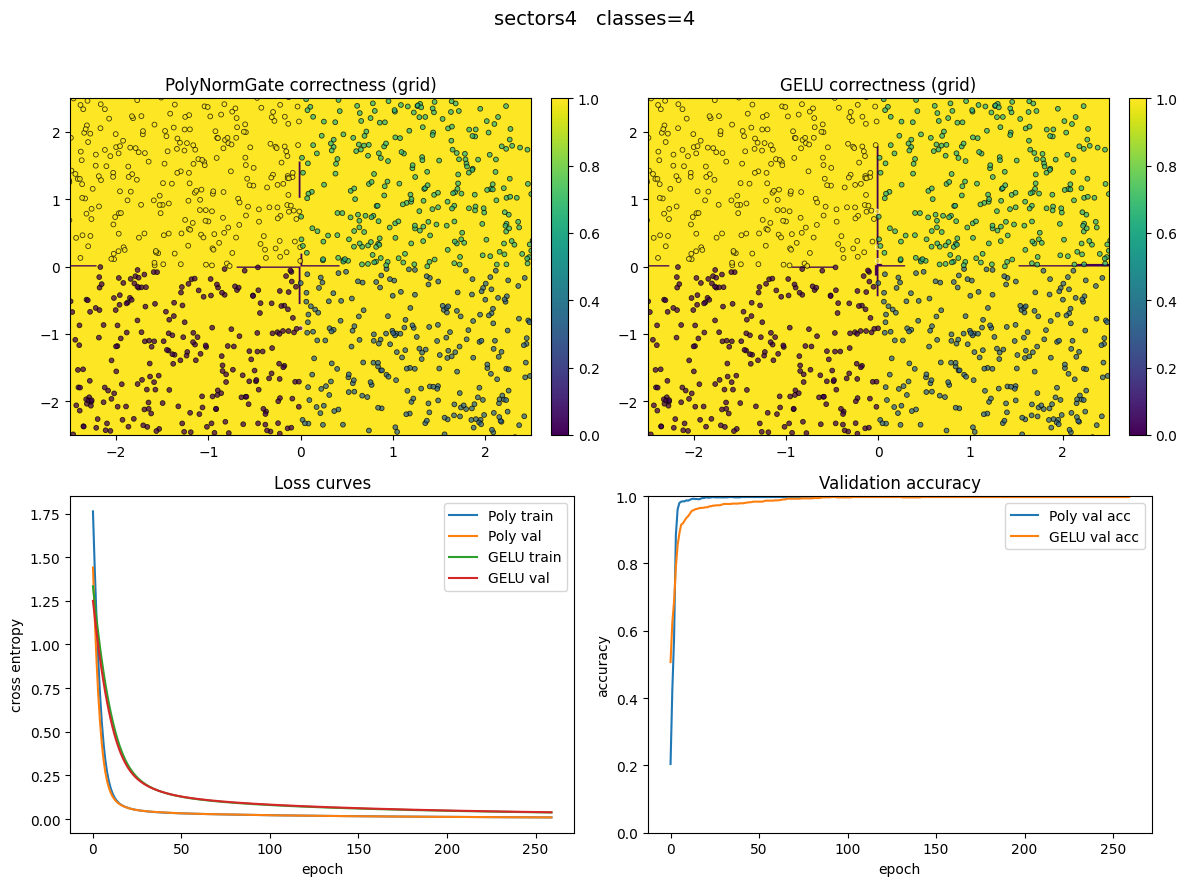

[10/12] gmm3            best_acc  poly=0.9961  gelu=0.9961   params poly=1155 gelu=1027


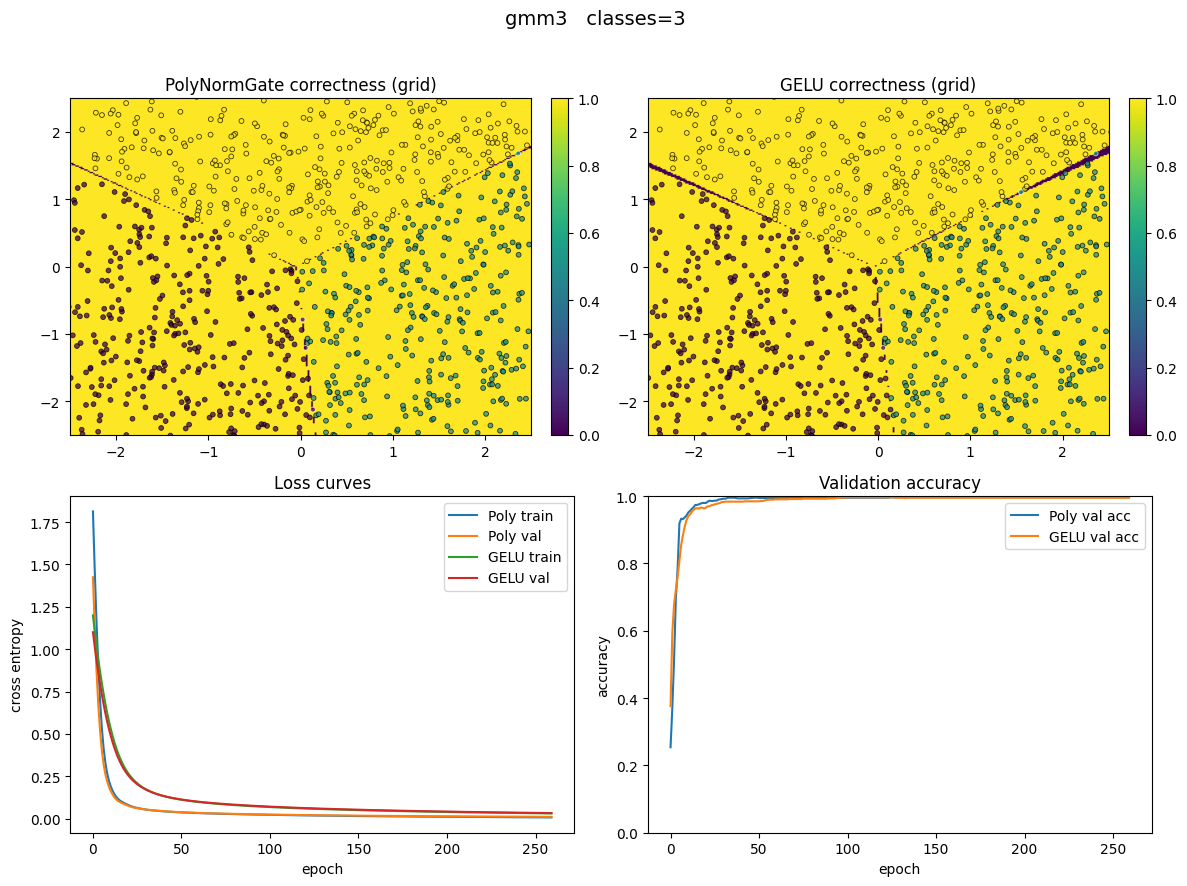

[11/12] concentric5     best_acc  poly=0.9873  gelu=0.9453   params poly=1413 gelu=1285


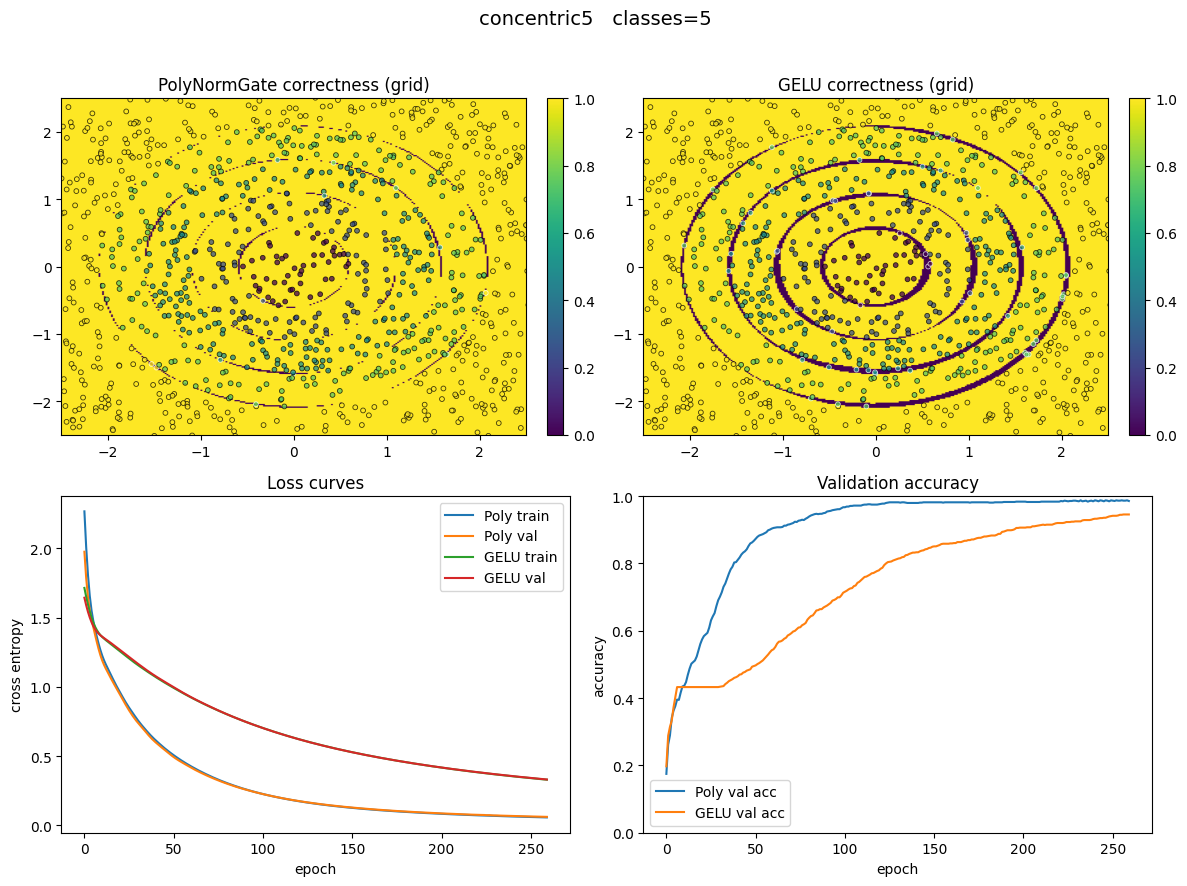

[12/12] wedges3         best_acc  poly=0.9756  gelu=0.9443   params poly=1155 gelu=1027


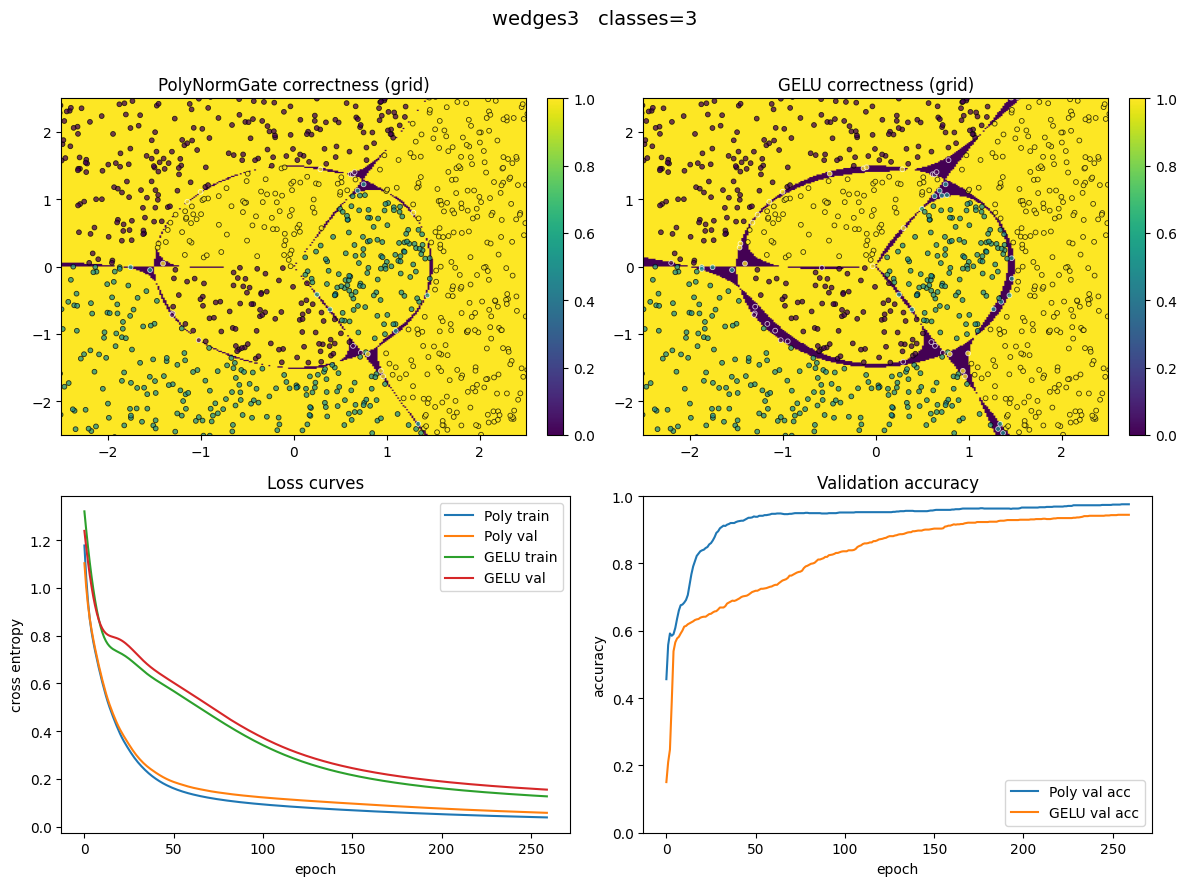

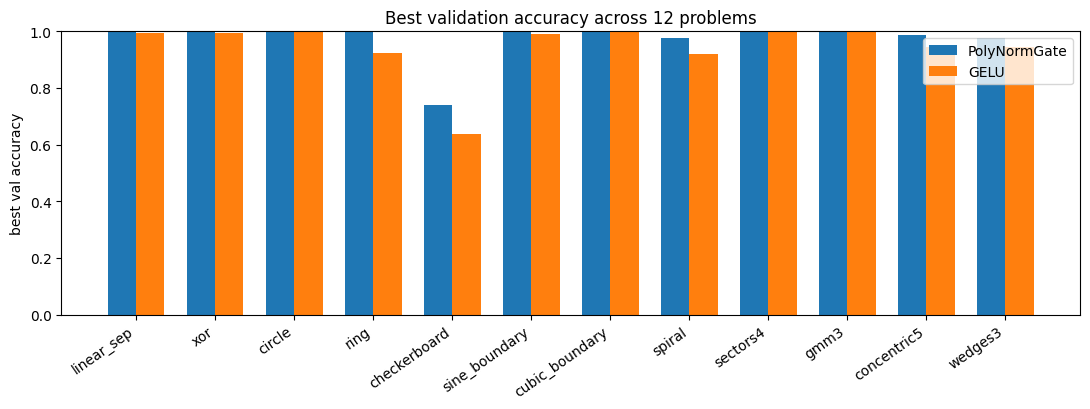

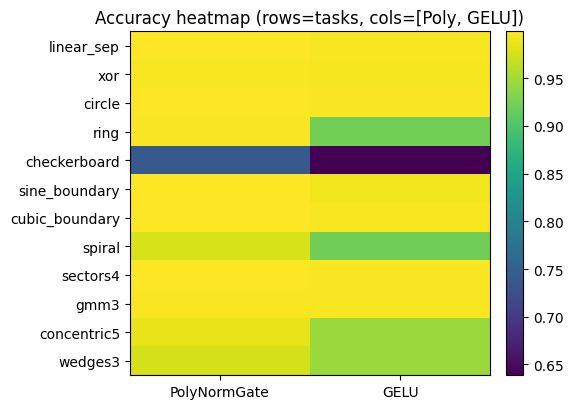

Mean best val accuracy:  PolyNormGate=0.9720  GELU=0.9448

Per-task summary:
linear_sep      classes=2  best_acc poly=0.9990 gelu=0.9951
xor             classes=2  best_acc poly=0.9961 gelu=0.9941
circle          classes=2  best_acc poly=0.9990 gelu=0.9971
ring            classes=2  best_acc poly=0.9971 gelu=0.9219
checkerboard    classes=2  best_acc poly=0.7393 gelu=0.6387
sine_boundary   classes=2  best_acc poly=0.9990 gelu=0.9912
cubic_boundary  classes=2  best_acc poly=0.9990 gelu=0.9961
spiral          classes=2  best_acc poly=0.9775 gelu=0.9209
sectors4        classes=4  best_acc poly=0.9990 gelu=0.9971
gmm3            classes=3  best_acc poly=0.9961 gelu=0.9961
concentric5     classes=5  best_acc poly=0.9873 gelu=0.9453
wedges3         classes=3  best_acc poly=0.9756 gelu=0.9443


In [1]:
#polynormgate is MIT by joshuah rainstar 2025 w/attribution


import math
from dataclasses import dataclass
from typing import Callable, Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----------------------------
# Models
# ----------------------------

class PolyNormGate(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        self.eps = 1e-6
        self.a = math.pi / math.sqrt(3.0)
        self.weight = nn.Parameter(torch.ones(dim) * 0.7049)

    def forward(self, u: torch.Tensor) -> torch.Tensor:
        z = u ** 2 + (torch.tanh(self.weight) + self.eps) * (u ** 3)
        h = z * torch.sigmoid(self.a * z)
        return h

class TwoLayerMLP(nn.Module):
    def __init__(self, d_in: int, d_hidden: int, d_out: int, act: nn.Module, use_layernorm: bool = True):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.ln1 = nn.LayerNorm(d_hidden) if use_layernorm else nn.Identity()
        self.act = act
        self.fc2 = nn.Linear(d_hidden, d_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())

# ----------------------------
# Synthetic problems (12)
# Each task supplies a label_fn usable on any (N,2) array for correctness maps
# ----------------------------

@dataclass
class Task:
    name: str
    n_classes: int
    bounds: Tuple[float, float, float, float]  # xmin, xmax, ymin, ymax
    X_train: np.ndarray
    y_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    label_fn: Callable[[np.ndarray], np.ndarray]

def make_tasks(seed: int = 0, n_train: int = 4096, n_val: int = 1024) -> List[Task]:
    rng = np.random.default_rng(seed)
    bounds = (-2.5, 2.5, -2.5, 2.5)

    def sample_uniform(n: int, noise: float) -> np.ndarray:
        xmin, xmax, ymin, ymax = bounds
        X = rng.uniform([xmin, ymin], [xmax, ymax], size=(n, 2))
        if noise > 0:
            X = X + rng.normal(scale=noise, size=X.shape)
        return X

    def add_task(name: str, n_classes: int, label_fn: Callable[[np.ndarray], np.ndarray], noise: float) -> Task:
        Xtr = sample_uniform(n_train, noise)
        Xva = sample_uniform(n_val, noise)
        ytr = label_fn(Xtr).astype(np.int64)
        yva = label_fn(Xva).astype(np.int64)
        return Task(name, n_classes, bounds, Xtr, ytr, Xva, yva, label_fn)

    tasks: List[Task] = []

    # 1) Linear separable (2-class)
    def f_linear(X):
        return (X[:, 0] + 0.8 * X[:, 1] > 0).astype(int)
    tasks.append(add_task("linear_sep", 2, f_linear, noise=0.10))

    # 2) XOR (2-class)
    def f_xor(X):
        return ((X[:, 0] > 0) ^ (X[:, 1] > 0)).astype(int)
    tasks.append(add_task("xor", 2, f_xor, noise=0.12))

    # 3) Circle (2-class)
    def f_circle(X, r=1.25):
        return (X[:, 0] ** 2 + X[:, 1] ** 2 > r ** 2).astype(int)
    tasks.append(add_task("circle", 2, lambda X: f_circle(X, 1.25), noise=0.10))

    # 4) Ring (2-class)
    def f_ring(X, r1=0.9, r2=1.6):
        r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
        return ((r > r1) & (r < r2)).astype(int)
    tasks.append(add_task("ring", 2, lambda X: f_ring(X, 0.9, 1.6), noise=0.08))

    # 5) Checkerboard (2-class)
    def f_checker(X, k=1.1):
        xx = X[:, 0] + 2.5
        yy = X[:, 1] + 2.5
        return ((np.floor(xx * k) + np.floor(yy * k)) % 2).astype(int)
    tasks.append(add_task("checkerboard", 2, lambda X: f_checker(X, 1.1), noise=0.06))

    # 6) Sine boundary (2-class)
    def f_sine_boundary(X):
        return (X[:, 1] > 0.8 * np.sin(1.6 * X[:, 0])).astype(int)
    tasks.append(add_task("sine_boundary", 2, f_sine_boundary, noise=0.10))

    # 7) Cubic boundary (2-class)
    def f_cubic_boundary(X):
        return (X[:, 1] > 0.35 * (X[:, 0] ** 3) - 0.3 * X[:, 0]).astype(int)
    tasks.append(add_task("cubic_boundary", 2, f_cubic_boundary, noise=0.10))

    # 8) Spiral (2-class)
    def f_spiral(X, c=2.35):
        r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2) + 1e-9
        theta = np.arctan2(X[:, 1], X[:, 0])
        val = (theta + c * r) % (2 * np.pi)
        return (val > np.pi).astype(int)
    tasks.append(add_task("spiral", 2, lambda X: f_spiral(X, 2.35), noise=0.05))

    # 9) Sectors (4-class)
    def f_sectors4(X):
        theta = np.arctan2(X[:, 1], X[:, 0]) + np.pi
        return np.floor(theta / (2 * np.pi / 4)).astype(int)
    tasks.append(add_task("sectors4", 4, f_sectors4, noise=0.08))

    # 10) Nearest-center (3-class)
    centers = np.array([[-1.2, -0.6], [1.2, -0.4], [0.0, 1.3]], dtype=float)
    def f_gmm3(X):
        d = ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
        return d.argmin(axis=1).astype(int)
    tasks.append(add_task("gmm3", 3, f_gmm3, noise=0.15))

    # 11) Concentric rings (5-class)
    def f_concentric5(X):
        r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
        bins = np.array([0.6, 1.1, 1.6, 2.1])
        return np.digitize(r, bins).astype(int)
    tasks.append(add_task("concentric5", 5, f_concentric5, noise=0.06))

    # 12) Wedges with radius interaction (3-class)
    def f_wedges3(X):
        theta = np.arctan2(X[:, 1], X[:, 0]) + np.pi
        r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
        c = np.floor(theta / (2 * np.pi / 3)).astype(int)  # 0..2
        c = (c + (r > 1.5).astype(int)) % 3
        return c.astype(int)
    tasks.append(add_task("wedges3", 3, f_wedges3, noise=0.08))

    return tasks

# ----------------------------
# Training and evaluation
# ----------------------------

def train_fullbatch_classification(
    task: Task,
    act_ctor: Callable[[int], nn.Module],
    d_hidden: int,
    epochs: int,
    lr: float,
    weight_decay: float,
    grad_clip: float,
    device: torch.device,
    seed: int,
    use_layernorm: bool = True,
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    torch.manual_seed(seed)
    np.random.seed(seed)

    Xtr = torch.tensor(task.X_train, dtype=torch.float32, device=device)
    ytr = torch.tensor(task.y_train, dtype=torch.long, device=device)
    Xva = torch.tensor(task.X_val, dtype=torch.float32, device=device)
    yva = torch.tensor(task.y_val, dtype=torch.long, device=device)

    model = TwoLayerMLP(2, d_hidden, task.n_classes, act_ctor(d_hidden), use_layernorm=use_layernorm).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    hist = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_val_acc = -1.0
    best_state = None

    for ep in range(epochs):
        model.train()
        opt.zero_grad(set_to_none=True)

        logits = model(Xtr)
        loss = loss_fn(logits, ytr)
        loss.backward()

        if grad_clip and grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        opt.step()

        model.eval()
        with torch.no_grad():
            logits_va = model(Xva)
            val_loss = loss_fn(logits_va, yva)
            val_acc = (logits_va.argmax(dim=1) == yva).float().mean()

        tr_loss = float(loss.detach().cpu().item())
        va_loss = float(val_loss.detach().cpu().item())
        va_acc = float(val_acc.detach().cpu().item())

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist

# ----------------------------
# Plotting
# ----------------------------

def correctness_map(
    task: Task,
    model: nn.Module,
    grid_res: int,
    device: torch.device,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    xmin, xmax, ymin, ymax = task.bounds
    xs = np.linspace(xmin, xmax, grid_res)
    ys = np.linspace(ymin, ymax, grid_res)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.stack([XX.ravel(), YY.ravel()], axis=1)

    y_true = task.label_fn(grid).astype(np.int64)

    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(grid, dtype=torch.float32, device=device))
        y_pred = logits.argmax(dim=1).detach().cpu().numpy().astype(np.int64)

    correct = (y_pred == y_true).astype(np.float32).reshape(grid_res, grid_res)
    y_true_img = y_true.reshape(grid_res, grid_res)
    y_pred_img = y_pred.reshape(grid_res, grid_res)
    return correct, y_true_img, y_pred_img, grid

def plot_task_results(
    task: Task,
    poly_model: nn.Module,
    gelu_model: nn.Module,
    poly_hist: Dict[str, List[float]],
    gelu_hist: Dict[str, List[float]],
    device: torch.device,
    grid_res: int = 260,
    max_points_overlay: int = 1200,
):
    xmin, xmax, ymin, ymax = task.bounds

    poly_corr, _, _, _ = correctness_map(task, poly_model, grid_res, device)
    gelu_corr, _, _, _ = correctness_map(task, gelu_model, grid_res, device)

    Xv = task.X_val
    yv = task.y_val

    rng = np.random.default_rng(0)
    if Xv.shape[0] > max_points_overlay:
        idx = rng.choice(Xv.shape[0], size=max_points_overlay, replace=False)
        Xv_s = Xv[idx]
        yv_s = yv[idx]
    else:
        Xv_s = Xv
        yv_s = yv

    def pred_on_points(model: nn.Module, X: np.ndarray) -> np.ndarray:
        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X, dtype=torch.float32, device=device))
            return logits.argmax(dim=1).detach().cpu().numpy().astype(np.int64)

    poly_pred_pts = pred_on_points(poly_model, Xv_s)
    gelu_pred_pts = pred_on_points(gelu_model, Xv_s)
    poly_ok = (poly_pred_pts == yv_s)
    gelu_ok = (gelu_pred_pts == yv_s)

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"{task.name}   classes={task.n_classes}", fontsize=14)

    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("PolyNormGate correctness (grid)")
    im1 = ax1.imshow(poly_corr, origin="lower", extent=[xmin, xmax, ymin, ymax], aspect="auto")
    ax1.scatter(Xv_s[:, 0], Xv_s[:, 1], c=yv_s, s=12, alpha=0.75, linewidths=0.6,
                edgecolors=np.where(poly_ok, "k", "w"))
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = plt.subplot(2, 2, 2)
    ax2.set_title("GELU correctness (grid)")
    im2 = ax2.imshow(gelu_corr, origin="lower", extent=[xmin, xmax, ymin, ymax], aspect="auto")
    ax2.scatter(Xv_s[:, 0], Xv_s[:, 1], c=yv_s, s=12, alpha=0.75, linewidths=0.6,
                edgecolors=np.where(gelu_ok, "k", "w"))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title("Loss curves")
    ax3.plot(poly_hist["train_loss"], label="Poly train")
    ax3.plot(poly_hist["val_loss"], label="Poly val")
    ax3.plot(gelu_hist["train_loss"], label="GELU train")
    ax3.plot(gelu_hist["val_loss"], label="GELU val")
    ax3.set_xlabel("epoch")
    ax3.set_ylabel("cross entropy")
    ax3.legend()

    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title("Validation accuracy")
    ax4.plot(poly_hist["val_acc"], label="Poly val acc")
    ax4.plot(gelu_hist["val_acc"], label="GELU val acc")
    ax4.set_xlabel("epoch")
    ax4.set_ylabel("accuracy")
    ax4.set_ylim(0.0, 1.0)
    ax4.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----------------------------
# Run benchmark (12 problems)
# ----------------------------

cfg = {
    "seed": 7,
    "n_train": 4096,
    "n_val": 1024,
    "d_hidden": 128,
    "epochs": 260,
    "lr": 2e-3,
    "weight_decay": 1e-4,
    "grad_clip": 1.0,
    "use_layernorm": True,
    "grid_res": 260,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tasks = make_tasks(seed=cfg["seed"], n_train=cfg["n_train"], n_val=cfg["n_val"])

def poly_ctor(dh: int) -> nn.Module:
    return PolyNormGate(dh)

def gelu_ctor(dh: int) -> nn.Module:
    return nn.GELU()

results = []
acc_matrix = np.zeros((len(tasks), 2), dtype=np.float32)

for ti, task in enumerate(tasks):
    run_seed_poly = 1000 + ti * 17 + 1
    run_seed_gelu = 1000 + ti * 17 + 2

    poly_model, poly_hist = train_fullbatch_classification(
        task=task,
        act_ctor=poly_ctor,
        d_hidden=cfg["d_hidden"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        grad_clip=cfg["grad_clip"],
        device=device,
        seed=run_seed_poly,
        use_layernorm=cfg["use_layernorm"],
    )

    gelu_model, gelu_hist = train_fullbatch_classification(
        task=task,
        act_ctor=gelu_ctor,
        d_hidden=cfg["d_hidden"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        grad_clip=cfg["grad_clip"],
        device=device,
        seed=run_seed_gelu,
        use_layernorm=cfg["use_layernorm"],
    )

    poly_final = float(poly_hist["val_acc"][-1])
    gelu_final = float(gelu_hist["val_acc"][-1])
    poly_best = float(np.max(poly_hist["val_acc"]))
    gelu_best = float(np.max(gelu_hist["val_acc"]))

    acc_matrix[ti, 0] = poly_best
    acc_matrix[ti, 1] = gelu_best

    results.append({
        "task": task.name,
        "classes": task.n_classes,
        "poly_params": count_params(poly_model),
        "gelu_params": count_params(gelu_model),
        "poly_val_acc_final": poly_final,
        "gelu_val_acc_final": gelu_final,
        "poly_val_acc_best": poly_best,
        "gelu_val_acc_best": gelu_best,
    })

    print(f"[{ti+1:02d}/12] {task.name:14s}  best_acc  poly={poly_best:.4f}  gelu={gelu_best:.4f}   params poly={count_params(poly_model)} gelu={count_params(gelu_model)}")

    plot_task_results(
        task=task,
        poly_model=poly_model,
        gelu_model=gelu_model,
        poly_hist=poly_hist,
        gelu_hist=gelu_hist,
        device=device,
        grid_res=cfg["grid_res"],
    )

# ----------------------------
# Summary plots
# ----------------------------

task_names = [t.name for t in tasks]

plt.figure(figsize=(11, 4.2))
plt.title("Best validation accuracy across 12 problems")
x = np.arange(len(task_names))
plt.bar(x - 0.18, acc_matrix[:, 0], width=0.36, label="PolyNormGate")
plt.bar(x + 0.18, acc_matrix[:, 1], width=0.36, label="GELU")
plt.xticks(x, task_names, rotation=35, ha="right")
plt.ylim(0.0, 1.0)
plt.ylabel("best val accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5.8, 4.2))
plt.title("Accuracy heatmap (rows=tasks, cols=[Poly, GELU])")
plt.imshow(acc_matrix, aspect="auto", origin="upper")
plt.yticks(np.arange(len(task_names)), task_names)
plt.xticks([0, 1], ["PolyNormGate", "GELU"])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

poly_mean = float(acc_matrix[:, 0].mean())
gelu_mean = float(acc_matrix[:, 1].mean())
print(f"Mean best val accuracy:  PolyNormGate={poly_mean:.4f}  GELU={gelu_mean:.4f}")

# results table in plain text
print("\nPer-task summary:")
for r in results:
    print(f"{r['task']:14s}  classes={r['classes']}  best_acc poly={r['poly_val_acc_best']:.4f} gelu={r['gelu_val_acc_best']:.4f}")
